# Runner script for InfoVAE
@author: Ishraque Zahin, 45129256

If you wish to run this locally please update `data.py` and `config.py` accordingly to ensure that your data loading paths are correct.

For information regarding InfoVAEs be sure to check the `README.md`

In [1]:
from IPython import display
import matplotlib.pyplot as plt
import tensorflow as tf
import time

### Data Imports
Firstly we need to import our data, and ensure that it's *normalised*.

Image data is usually in the range 0-255 for RGBA values, thus we want to divide by 255 to bring it to the range 0-1. This makes performing gradient descent a lot easier.

Using the tensorflow datasets' built in [`.map()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) function we can *lazy load* this transformation/normalisation operation.

In [2]:
# Load data and vars
from data import train_x, test_x, valid_x, batch_size

# normalise data
train_dataset = train_x.map(lambda x: x / 255.)
test_dataset = test_x.map(lambda x: x / 255.)

Found 544 files belonging to 1 classes.
Found 9664 files belonging to 1 classes.
Found 1120 files belonging to 1 classes.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the f

### Initialise model
See `model.py` for full model reference.

We can adjust the *latent dimensions* of our model by providing it as a parameter. Set this to 2 if you wish to visualise the latent space in 2 Dimensions. To generate clear images it's recommened to set this to 32.

In [3]:
# load model and set our latent dimensions
from model import InfoVAE
latent_dim = 32
model = InfoVAE(latent_dim)
model.model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
functional_1 (Functional)    (None, 32)                260139680 
_________________________________________________________________
functional_3 (Functional)    (None, 256, 256, 1)       33731201  
Total params: 293,870,881
Trainable params: 293,870,881
Non-trainable params: 0
_________________________________________________________________


### Some helper functions
Note that the output directory is defined in `config.py`. We also defined a sample random normal vector of the same dimension as our latent space that we shall use to generate images. This allows us to view the gradual improvement on the same input noise. 

We also define a small helper function to generate and save our images.

In [4]:
from config import output_dir

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(shape=[batch_size, latent_dim])

def generate_and_save_images(model, epoch, random_vector_for_generation):
    print("Generated images:")
    predictions = model.decoder(random_vector_for_generation)
    fig = plt.figure(figsize=(4, 4))
    for i in range(16): # our subplot is 4x4 so only load 16 plots
                        # assuming we have 16 random generations
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig(f"{output_dir}/image_at_epoch_{epoch}.png", dpi=300)
    plt.show()

### Main training loop
If you wish to train for more epochs, change the `range(1, n)` to `n` epochs as desired.

On each epoch we are also running our `generate_and_save_images()` function to visualise and track learning. 

Reconstruction SSIM: 0.7084110975265503
Epoch: 5, Test set Loss: 0.010037184692919254, Training set loss: 0.008478117175400257, time elapse for current epoch: 49.800148725509644
Generated images:


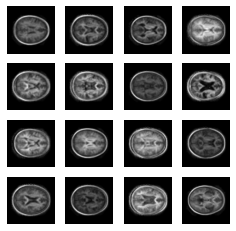

In [5]:
generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, 6):
    start_time = time.time()
    training_loss = -1
    ssim = 0
    for train_x in train_dataset:
        training_loss = model.train(train_x)
        recon = model.model(train_x)
        ssim += tf.image.ssim(train_x, recon, max_val=1.0, filter_size=11,
                            filter_sigma=1.5, k1=0.01, k2=0.03)
    end_time = time.time()
    test_loss = 0
    for t in test_dataset:
        test_loss += model.get_loss(t)
    display.clear_output(wait=False)
#     print_generation_ssim()
    print(f"Reconstruction SSIM: {tf.reduce_mean(ssim, axis=None) / len(train_dataset)}")
    print(f"Epoch: {epoch}, Test set Loss: {test_loss/len(test_dataset)}, Training set loss: {training_loss}, time elapse for current epoch: {end_time - start_time}")
    generate_and_save_images(model, epoch, random_vector_for_generation)